In [1]:
import pandas as pd
import numpy as np

# Read the cleaned file into a DataFrame
df = pd.read_csv('../data/bgg_rating_threshold.csv', sep=';', engine='c')

# Convert the 'bgg_user_rating' column to numeric
df['bgg_user_rating'] = ((pd.to_numeric(df['bgg_user_rating'], errors='coerce'))*10).astype(np.uint8)

print("done")

done


In [2]:
from scipy.sparse import coo_matrix
from sklearn.decomposition import TruncatedSVD
data = list(df.itertuples(index=False, name=None))
# Alternatively, you can use df['item'], df['user'], and df['review_score'] directly.

# Create unique mappings for items and users
unique_items = sorted(df['bgg_id'].unique())
unique_users = sorted(df['bgg_user_name'].unique())

item_to_index = {item: idx for idx, item in enumerate(unique_items)}
user_to_index = {user: idx for idx, user in enumerate(unique_users)}

# Prepare row indices, column indices, and data (review scores) using the DataFrame columns
rows = df['bgg_id'].map(item_to_index)
cols = df['bgg_user_name'].map(user_to_index)
scores = df['bgg_user_rating']

# Create a sparse matrix using the COO format:
sparse_matrix = coo_matrix(
    (scores, (rows, cols)),
    shape=(len(unique_items), len(unique_users))
)

# Optionally convert to CSR format for more efficient arithmetic operations
sparse_matrix = sparse_matrix.tocsr()
print ("Sparse matrix created with shape:", sparse_matrix.shape)

Sparse matrix created with shape: (15738, 411956)


In [3]:
import csv

# Write the unique_items list to a CSV file
with open('../data/bgg_id.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([[item] for item in unique_items])

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(sparse_matrix)

In [6]:
import matplotlib.pyplot as plt
# Define the number of components for SVD (adjust based on your application)
n_components = 1000  # This is a hyperparameter; change it to suit your needs

# Initialize and fit TruncatedSVD
svd = TruncatedSVD(n_components=n_components)
X_latent = svd.fit_transform(X_scaled)
print(svd.explained_variance_ratio_.sum())

0.7178186363671515


In [38]:
from sklearn.neighbors import kneighbors_graph
k = 150
# mode='distance' yields distances; mode='connectivity' yields 0/1 links
knn_dist = kneighbors_graph(X_latent, n_neighbors=k, mode='distance', include_self=False)
# Convert distances to weights, e.g. w = exp(-d)
knn_weights = knn_dist.copy()
knn_weights.data = np.exp(-knn_weights.data)

In [39]:
import igraph as ig
# 5. Build an igraph Graph from the sparse matrix
#    Note: igraph expects a dense adjacency or edge list with weights
sources, targets = knn_weights.nonzero()
weights = knn_weights.data
g=ig.Graph.Weighted_Adjacency(knn_weights)

In [40]:
import leidenalg
partition = leidenalg.find_partition(g,leidenalg.ModularityVertexPartition,seed=0)
communities = partition.membership
print("Leiden communities modularity:", partition.modularity)

Leiden communities modularity: 0.569974566153026


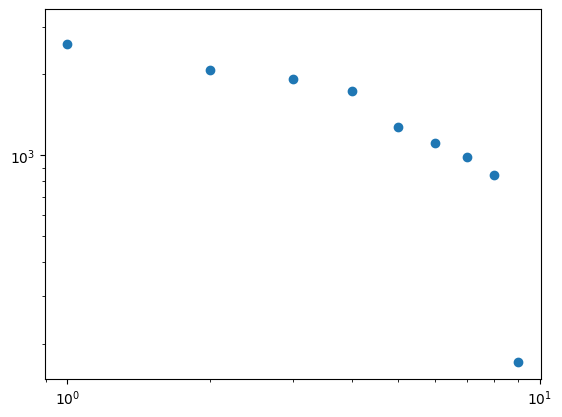

In [41]:
import matplotlib.pyplot as plt

unique_clusters, counts = np.unique(communities, return_counts=True)
cluster_counts = dict(zip(unique_clusters, counts))
plt.loglog(cluster_counts.keys(), cluster_counts.values(), 'o')

In [36]:
indices = [i for i, j in enumerate(communities) if j == 22]
df_game_item_from_bgg = pd.read_csv('../data/boardgames_ranks.csv') 
for index in indices:
    bgg_id = unique_items[index]
    name = df_game_item_from_bgg[df_game_item_from_bgg['id'].isin([bgg_id])]['name']
    print(name.to_string())

In [20]:
import umap
reducer = umap.UMAP()
coords = reducer.fit_transform(X_latent)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


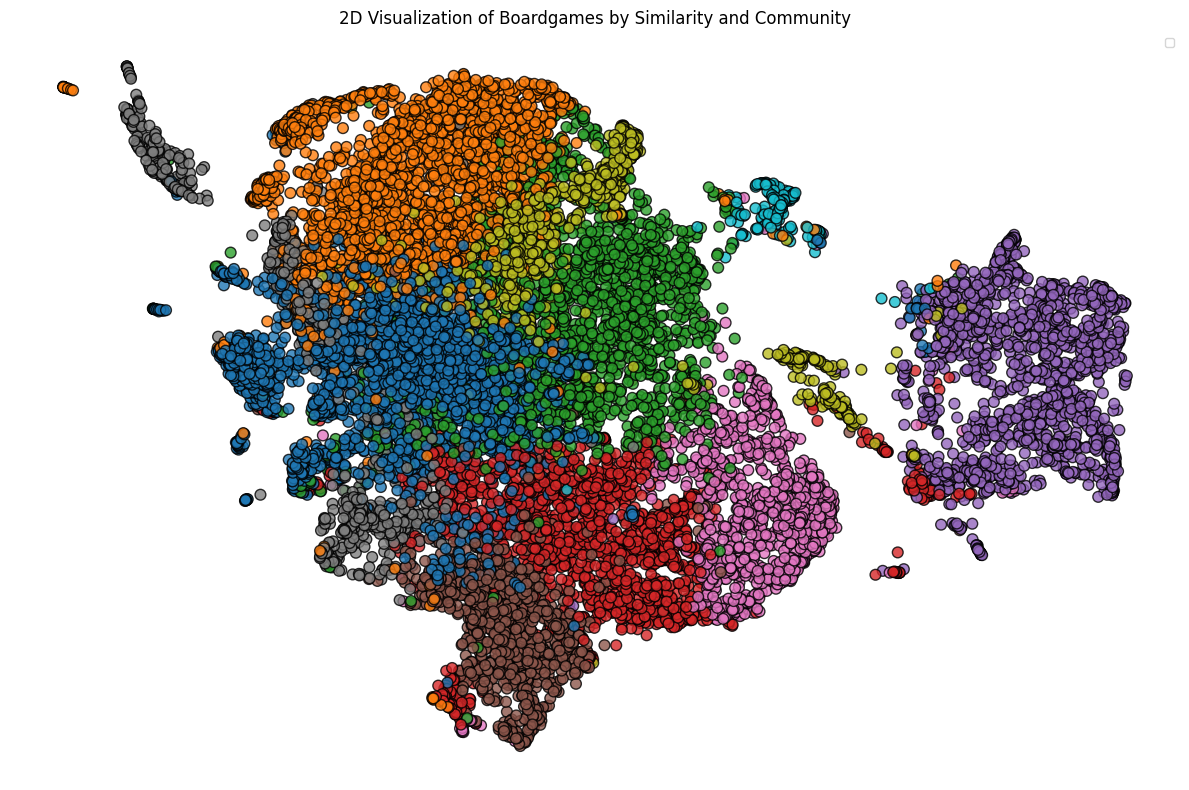

In [51]:
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

# Step 5: Plotting
plt.figure(figsize=(12, 8))

plt.scatter(coords[:, 0], coords[:, 1], c=communities,cmap='tab10', s=60, alpha=0.8, edgecolor='k')

# Add legend without duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', fontsize='small')

plt.title("2D Visualization of Boardgames by Similarity and Community")
plt.axis('off')
plt.tight_layout()
plt.show()